# Data Investigation - Trip Data

### Import Data

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
from scipy import stats
import math
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob

import seaborn as sns
sns.set()

## Load trip Data

In [2]:
print('Loading Trip Data...')

try:
    file_path_slug = '../../datasets/bayareabikeshare/*_trip_data.csv'

    # glob all files
    file_list = glob(file_path_slug)

    trip_import = pd.DataFrame()

    counter = 1
    chunks = []

    # load data from each file
    for file in file_list:

        # import file in chunks
        for chunk in pd.read_csv(file, chunksize=10000, iterator=True):

            # set chunk index column to 'Trip ID'
            chunk = chunk.set_index('Trip ID')

            # define Columns
            chunk.columns = ['Duration', 'Start Date', 'Start Station', 'Start Terminal', 'End Date', 
                             'End Station', 'End Terminal', 'Bike #', 'Subscriber Type', 'Zip Code']

            # append chunk to chunks list
            chunks.append(chunk)

        print('\tFinished file! (%d of %d)' % (counter, len(file_list)))
        counter += 1

    # concat chunks
    trip_import = pd.concat(chunks)

    print('Data Loaded Successfully!')

except:
    print('oops... something went wrong importing the data :(')

Loading Trip Data...
	Finished file! (1 of 4)
	Finished file! (2 of 4)
	Finished file! (3 of 4)
	Finished file! (4 of 4)
Data Loaded Successfully!


### Clean Data

In [3]:
trip_data = trip_import.copy()
trip_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 983648 entries, 913465 to 198776
Data columns (total 10 columns):
Duration           983648 non-null int64
Start Date         983648 non-null object
Start Station      983648 non-null object
Start Terminal     983648 non-null int64
End Date           983648 non-null object
End Station        983648 non-null object
End Terminal       983648 non-null int64
Bike #             983648 non-null int64
Subscriber Type    983648 non-null object
Zip Code           976838 non-null object
dtypes: int64(4), object(6)
memory usage: 82.6+ MB


In [4]:
# zipcodes are all over the place, only keep corrected 5 digit zipcodes, and replace all others with NaNs
def clean_zipcode(item):
    if len(item) != 5:

        # split on '-'
        try:
            result = item.split('-')[0]
        except:
            result = item

        # split on '.'
        try:
            result = item.split('.')[0]
        except:
            result = item
        
        # if len of item is less than 5, return 'NaN'
        if len(result) < 5:
            result = 'NaN'
        else:
            # if len result is greater than 5, take at most, first 5 digits
            result = result[:5]
    else:
        result = item
    
    # make sure result is all digits
    if result.isdigit():
        return result
    else:
        return 'NaN'

In [ ]:
# zipcodes are all over the place, only keep corrected 5 digit zipcodes, and replace all others with NaNs
def clean_zipcode(item):
    if len(item) != 5:

        # split on '-'
        try:
            result = item.split('-')[0]
        except:
            result = item

        # split on '.'
        try:
            result = item.split('.')[0]
        except:
            result = item
        
        # if len of item is less than 5, return 'NaN'
        if len(result) < 5:
            result = 'NaN'
        else:
            # if len result is greater than 5, take at most, first 5 digits
            result = result[:5]
    else:
        result = item
    
    # make sure result is all digits
    if result.isdigit():
        return result
    else:
        return 'NaN'

In [6]:
print('Trip Data Cleanup Started...')

# cleanup column names
print('\tcleaning column names')
new_cols = []
for col in trip_data.columns:
    new_cols.append(col.replace(' ', '_').lower())
trip_data.columns = new_cols

# extract columns we want to keep
print('\tsubsetting to useful columns')
important_cols = ['duration', 'start_date', 'start_terminal', 'end_date', 'end_terminal', 'bike_#', 'subscriber_type', 'zip_code']
trip_data = trip_data[important_cols]

# we are only looking at stations in San Francisco
# sf_trips_data = trip_data[trip_data['start_terminal'].isin(sf_stations)]
# sf_trips_data = sf_trips_data[sf_trips_data['end_terminal'].isin(sf_stations)]

# trip_data = sf_trips_data.copy()

# create duration minutes column
print('\tcreating a duration_minutes column')
trip_data['duration_minutes'] = trip_data['duration'] / 60.0

# convert end and start dates to datetime objects
print('\tconverting end and start dates to datetime objects')
trip_data['start_date'] = pd.to_datetime(trip_data['start_date'], format="%m/%d/%Y %H:%M")
trip_data['end_date']   = pd.to_datetime(trip_data['end_date'],   format="%m/%d/%Y %H:%M")

# create a start and end hour trip column
print('\tcreating trip_date and trip_dow columns')
trip_data['trip_date']  = trip_data['start_date'].dt.date
trip_data['trip_dow']  = trip_data['start_date'].dt.weekday
trip_data['trip_day']  = trip_data['start_date'].dt.weekday_name

print('\tcreating start_hour and end_hour columns')
trip_data['start_hour'] = trip_data['start_date'].dt.hour
trip_data['end_hour']   = trip_data['end_date'].dt.hour

# convert and clean zipcodes
print('\tcleaning zipcodes')
trip_data['zip_code'] = trip_data['zip_code'].astype(str)
trip_data.zip_code = trip_data.zip_code.apply(clean_zipcode)
trip_data['zip_code'] = pd.to_numeric(trip_data['zip_code'], errors='coerce')

# clean up data types
print('cleaning up data types')

trip_data['duration']         = trip_data['duration'].astype('float')
# trip_data['start_date']       = trip_data['start_date'].astype('')
trip_data['start_terminal']   = trip_data['start_terminal'].astype('category')
# trip_data['end_date']         = trip_data['end_date'].astype('')
trip_data['end_terminal']     = trip_data['end_terminal'].astype('category')
trip_data['bike_#']           = trip_data['bike_#'].astype('int')
trip_data['subscriber_type']  = trip_data['subscriber_type'].astype('category')
trip_data['zip_code']         = trip_data['zip_code'].astype('str')
trip_data['duration_minutes'] = trip_data['duration_minutes'].astype('float')
# trip_data['trip_date']        = trip_data['trip_date'].astype('')
trip_data['trip_dow']         = trip_data['trip_dow'].astype('category')
trip_data['trip_day']         = trip_data['trip_day'].astype('category')
# trip_data['start_hour']       = trip_data['start_hour'].astype('')
# trip_data['end_hour']         = trip_data['end_hour'].astype('')


print('Trip Data Cleanup complete')
trip_clean = trip_data.copy()

Trip Data Cleanup Started...
	cleaning column names
	subsetting to useful columns
	creating a duration_minutes column
	converting end and start dates to datetime objects
	creating trip_date and trip_dow columns
	creating start_hour and end_hour columns
	cleaning zipcodes
cleaning up data types
Trip Data Cleanup complete


In [7]:
trip_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 983648 entries, 913465 to 198776
Data columns (total 14 columns):
duration            983648 non-null float64
start_date          983648 non-null datetime64[ns]
start_terminal      983648 non-null category
end_date            983648 non-null datetime64[ns]
end_terminal        983648 non-null category
bike_#              983648 non-null int64
subscriber_type     983648 non-null category
zip_code            983648 non-null object
duration_minutes    983648 non-null float64
trip_date           983648 non-null object
trip_dow            983648 non-null category
trip_day            983648 non-null category
start_hour          983648 non-null int64
end_hour            983648 non-null int64
dtypes: category(5), datetime64[ns](2), float64(2), int64(3), object(2)
memory usage: 79.7+ MB


### Prune Data - Trip Duration

pruning data to trips no more than 60 minutes long...
	pruned data set 'trips' consists of 955557 entries


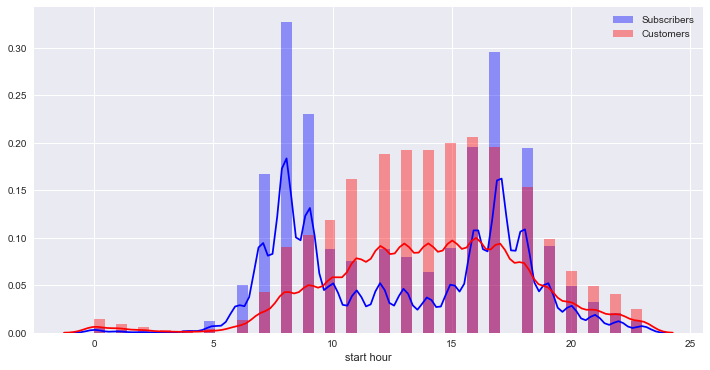

In [8]:
# prune data to exclude trips longer than 60 minutes
print('pruning data to trips no more than 60 minutes long...')
trips = trip_clean[trip_clean['duration_minutes'] <= 60].copy()

# Cleanup
trips.sort_index(inplace=True)
print('\tpruned data set \'trips\' consists of %i entries' % len(trips.index))

plt.subplots(figsize=(12,6))
ax = sns.distplot(trips[trips.subscriber_type == 'Subscriber'].start_date.dt.hour, color='b', label='Subscribers')
sns.distplot(trips[trips.subscriber_type == 'Customer'].start_date.dt.hour, color='r', label='Customers', ax=ax)
ax.set(xlabel='start hour')
plt.legend()
plt.show()

## Load Station Data

In [ ]:
trips_subscribers = trips[trips['subscriber_type'] == 'Subscriber']
print('trips_subscribers contains %s rows' % len(trips_subscribers.index))
trips_customers   = trips[trips['subscriber_type'] == 'Customer']
print('trips_customers contains %s rows' % len(trips_customers.index))

In [ ]:
print('trips_customers.duration_minutes.mean():\t', trips_customers.duration_minutes.mean())
print('trips_customers.duration_minutes.median():\t', trips_customers.duration_minutes.median())
print('trips_customers.duration_minutes.sum():\t\t', trips_customers.duration_minutes.sum())

print()
print('trips_subscribers.duration_minutes.mean():\t', trips_subscribers.duration_minutes.mean())
print('trips_subscribers.duration_minutes.median():\t', trips_subscribers.duration_minutes.median())
print('trips_subscribers.duration_minutes.sum():\t', trips_subscribers.duration_minutes.sum())

In [ ]:
ax = sns.distplot(trips[trips.subscriber_type == 'Subscriber'].day_of_week, color='b', label='Subscriber')
ax.set(xlabel='Day of the Week')
plt.legend()
plt.show()

In [ ]:
ax = sns.distplot(trips[trips.subscriber_type == 'Customer'].day_of_week, color='y', label='Customer')
ax.set(xlabel='Day of the Week')
plt.legend()
plt.show()

In [ ]:
sns.jointplot('day_of_week', 'start_hour', data=trips_subscribers, kind='kde')
plt.show()

In [ ]:
sns.jointplot('day_of_week', 'duration_minutes', data=trips_customers, kind='kde')
plt.show()

In [ ]:
# find popular routes for customers

In [ ]:
sns.lmplot('start_terminal', 'end_terminal',
              data=trips_customers,
              fit_reg=False,
              hue='duration_minutes')


In [ ]:
sns.lmplot(x='start_hour', y='duration_minutes', data=trips,
          fit_reg=False, hue='subscriber_type')

In [ ]:
sns.lmplot(y='start_hour', x='duration_minutes', 
           data=trip_clean[trip_clean['duration_minutes'] < 1440],
           fit_reg=False, hue='subscriber_type')

In [ ]:
trips_over1Day = trip_clean[trip_clean['duration_minutes'] >= 1440]
trips_over1Day = trips_over1Day[trips_over1Day['duration_minutes'] < 15000]

sns.lmplot(y='start_hour', x='duration_minutes', 
           data=trips_over1Day,
           fit_reg=False, hue='subscriber_type')

In [ ]:
trips.groupby('subscriber_type')['duration'].count()

In [ ]:
route_counts = trips.groupby(['subscriber_type', 'start_terminal', 'end_terminal'])['duration'].count().to_frame()
route_counts.reset_index(inplace=True)
route_counts.columns = ['subscriber_type', 'start_terminal', 'end_terminal', 'trip_count']
route_counts['subscriber_type'].astype('category')
route_counts.head()

In [ ]:
def colorize_subscriber_type(category):
    if category.lower() == 'subscriber':
        return 'r'
    elif category.lower() == 'customer':
        return 'b'
    else:
        return 'g'

In [ ]:
route_counts['trip_count_norm'] = route_counts['trip_count'] / route_counts['trip_count'].max() * 100

# append color column
route_counts['color'] = route_counts['subscriber_type'].apply(colorize_subscriber_type)

route_counts.head()

In [ ]:
route_counts.plot.scatter(x='start_terminal', 
                          y='end_terminal', 
                          s=route_counts['trip_count_norm'] * 2, 
                          c=route_counts['color'],
                          alpha=0.25,
                          figsize=(20,10))

plt.show()

In [ ]:
routes_mean = trips.groupby(['start_terminal', 'end_terminal'])['duration_minutes'].mean().to_frame()
routes_max = trips.groupby(['start_terminal', 'end_terminal'])['duration_minutes'].max().to_frame()
routes_min = trips.groupby(['start_terminal', 'end_terminal'])['duration_minutes'].min().to_frame()
routes_count = trips.groupby(['start_terminal', 'end_terminal'])['duration_minutes'].mean().to_frame()


# df_merged = df1.merge(df2, how='outer', left_index=True, right_index=True)
trip_routes = routes_mean.merge(routes_min, how='outer', left_index=True, right_index=True)
trip_routes = trip_routes.merge(routes_max, how='outer', left_index=True, right_index=True)
trip_routes = trip_routes.merge(routes_count, how='outer', left_index=True, right_index=True)


trip_routes.columns = ['duration_minutes_mean',
                      'duration_minutes_min',
                      'duration_minutes_max',
                      'duration_minutes_count']
trip_routes.head()